# Wav Analysis

## Load WAV file

In [21]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting capabilities
import sounddevice as sd
import os

WAV_FILE_NAME = "Carmen nota 1.wav"

# Step 1: Load the wav file
sample_rate, data = wavfile.read(WAV_FILE_NAME)

# Ensure data is in the right format (mono signal)
if len(data.shape) > 1:
    data = data[:, 0]  # Take the first channel if stereo

# Step 2: Time and frequency parameters
N = len(data)  # Number of samples
T = N / sample_rate  # Total duration of the signal
t = np.linspace(0, T, N, endpoint=False)  # Time vector


## Execute the wav file

In [2]:
P = 4
# Repeat the waveform P times using np.tile
data_repeated = np.tile(data, P)

# Play the repeated waveform using sounddevice
sd.play(data_repeated, samplerate=sample_rate)

# Wait until the playback is finished
sd.wait()


## Plot the wav file

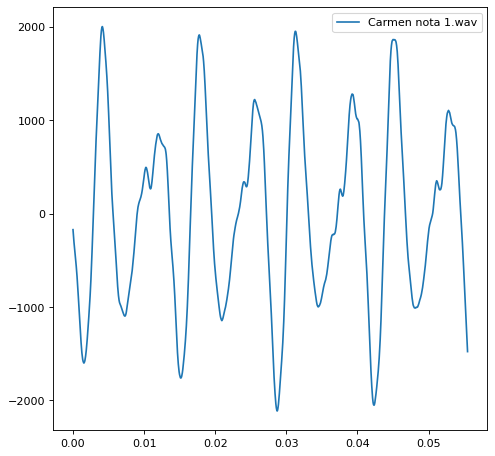

In [22]:
plt.figure(figsize=(7, 7), dpi=80)
plt.plot(t, data, label=WAV_FILE_NAME)
plt.legend()
plt.show()

## Fourier coefficients

In [23]:
# Step 3: Perform FFT to get frequency components
fft_values = np.fft.fft(data)
frequencies = np.fft.fftfreq(N, 1/sample_rate)

# Step 4: Define fundamental frequency (f0) manually or from the FFT
f0 = frequencies[np.argmax(np.abs(fft_values[:N//2]))]  # Approximate f0 as the peak in FFT

print(f"Fundamental frequency: {f0:.2f} Hz")


Fundamental frequency: 144.12 Hz


## FFT plot

In [42]:
def plot_fft_magnitude(sample_rate, data):
    # Perform FFT on the data
    fft_values = np.fft.fft(data)
    N = len(data)
    
    # Compute the frequencies corresponding to the FFT values
    frequencies = np.fft.fftfreq(N, d=1/sample_rate)
    
    # Take the magnitude (absolute value) of the FFT values
    magnitude = np.abs(fft_values)[:N // 2]  # Only positive frequencies
    frequencies = frequencies[:N // 2]       # Only positive frequencies

    # Plot the FFT magnitude spectrum
    plt.figure(figsize=(8, 4))
    plt.bar(frequencies[:20], magnitude[:20], color='blue')
    plt.title("FFT Magnitude Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()


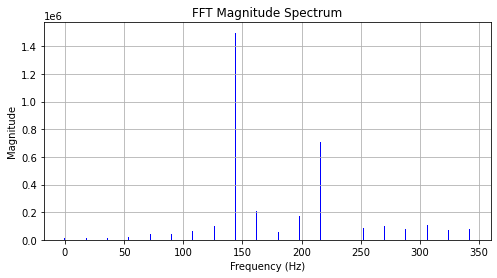

In [43]:
plot_fft_magnitude(sample_rate, data)

In [39]:
print(f"Frequencies: {frequencies[0]} - {frequencies[1]} - {frequencies[2]}")
print(f"FFT values: {fft_values[0]} - {fft_values[1]} - {fft_values[2]}")

Frequencies: 0.0 - 18.014705882352942 - 36.029411764705884
FFT values: (-11528+0j) - (-12423.114564958709+5040.686134884098j) - (-11514.216330424897+11938.612215963145j)


In [5]:
f0 = f0/2

In [6]:

# Step 5: Calculate Fourier coefficients for sine and cosine
def fourier_coefficients(data, f0, harmonics, t):
    T = max(t)
    a_n = []  # Cosine coefficients
    b_n = []  # Sine coefficients

    for n in range(harmonics + 1):  # 0 is the DC component, so start from 0
        cos_term = np.cos(2 * np.pi * n * f0 * t)
        sin_term = np.sin(2 * np.pi * n * f0 * t)

        # Calculate coefficients
        a_n.append(2 * np.dot(data, cos_term) / N)
        b_n.append(2 * np.dot(data, sin_term) / N)

    return a_n, b_n

# Step 6: Specify the number of harmonics you want to compute
harmonics = 10
a_n, b_n = fourier_coefficients(data, f0, harmonics, t)

# Step 7: Plot the results or return coefficients
print(f"Fundamental frequency: {f0:.2f} Hz")
print("Cosine coefficients (a_n):", a_n)
print("Sine coefficients (b_n):", b_n)



Fundamental frequency: 91.23 Hz
Cosine coefficients (a_n): [18.363260239966902, -7.066581234680994, 400.14560497854666, 126.01198020410799, 56.59195590963274, -22.854328670444808, 23.97644721582501, -13.956680227745675, 1.3177917055600088, 3.520811111756072, -1.4109219797981023]
Sine coefficients (b_n): [0.0, 11.856414911607182, 16.593972418123744, 188.79454887690713, 73.69503312640062, -16.541507309724082, 5.468466948009251, -7.35096350914357, -3.9623470757267274, -11.29130519970845, 5.739701507369665]


## Original vs Reconstructed waveform

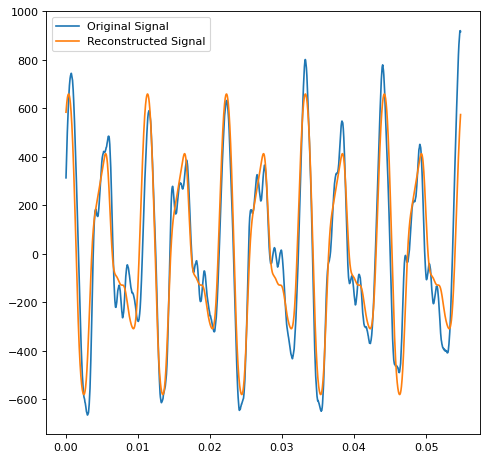

In [7]:
# Step 8: Plot original signal and reconstructed signal
def reconstruct_signal(a_n, b_n, f0, harmonics, t):
    reconstructed = np.zeros(len(t))
    for n in range(harmonics + 1):
        reconstructed += a_n[n] * np.cos(2 * np.pi * n * f0 * t)
        reconstructed += b_n[n] * np.sin(2 * np.pi * n * f0 * t)
    return reconstructed

reconstructed_signal = reconstruct_signal(a_n, b_n, f0, harmonics, t)

plt.figure(figsize=(7, 7), dpi=80)
plt.plot(t, data, label="Original Signal")
plt.plot(t, reconstructed_signal, label="Reconstructed Signal")
plt.legend()
plt.show()


## Original vs fundamental frequency

Fundamental waveform: y(t) = 18.36 * cos(2pi*f0*t) + 0.00 * sin(2pi*f0*t)


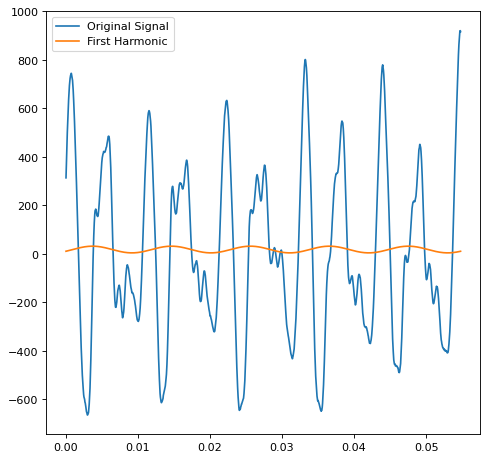

In [8]:
fundamental_signal = reconstruct_signal(a_n=a_n, b_n=b_n, f0=f0, harmonics=1, t=t)

print(f"Fundamental waveform: y(t) = {a_n[0]:.2f} * cos(2pi*f0*t) + {b_n[0]:.2f} * sin(2pi*f0*t)")


plt.figure(figsize=(7, 7), dpi=80)
plt.plot(t, data, label="Original Signal")
plt.plot(t, fundamental_signal, label="First Harmonic")
plt.legend()
plt.show()


## Plot individual harmonics

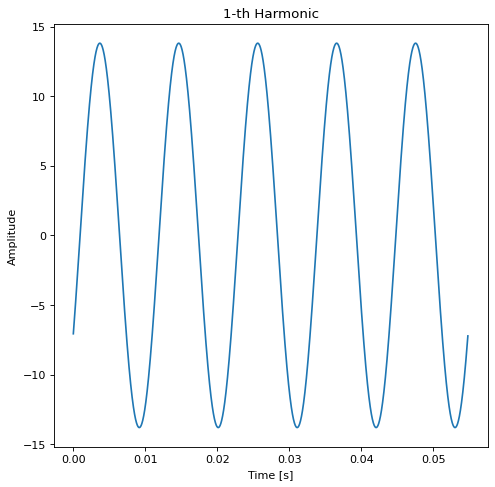

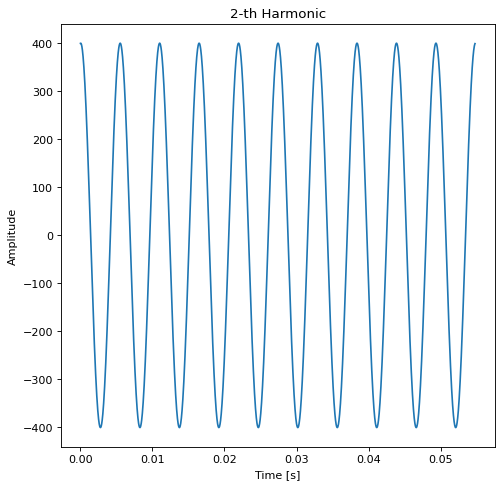

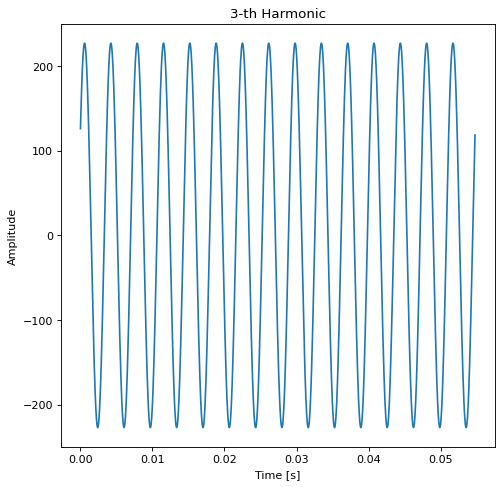

In [9]:
# Step 8: Function to plot the n-th harmonic
def plot_nth_harmonic(n, a_n, b_n, f0, t):
    # Compute the nth harmonic signal
    nth_harmonic = a_n[n] * np.cos(2 * np.pi * n * f0 * t) + b_n[n] * np.sin(2 * np.pi * n * f0 * t)
    
    # Plot the nth harmonic
    plt.figure(figsize=(7, 7), dpi=80)
    plt.plot(t, nth_harmonic, label=f"{n}-th Harmonic")
    plt.title(f"{n}-th Harmonic")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    #     plt.legend()
    plt.show()

# Plot the 1st harmonic
n = 1
plot_nth_harmonic(n, a_n, b_n, f0, t)
# Plot the 2nd harmonic
n = 2
plot_nth_harmonic(n, a_n, b_n, f0, t)
# Plot the 3rd harmonic
n = 3
plot_nth_harmonic(n, a_n, b_n, f0, t)



## Plot and play multiple harmonics

In [10]:
# Step 9: Function to plot waveform considering up to n harmonics
def plot_waveform_with_n_harmonics(n, a_n, b_n, f0, t):
    # Initialize the waveform to 0
    waveform = np.zeros(len(t))
    
    # Add contributions from the fundamental frequency and up to the n-th harmonic
    for i in range(n + 1):
        waveform += a_n[i] * np.cos(2 * np.pi * i * f0 * t) + b_n[i] * np.sin(2 * np.pi * i * f0 * t)
    
    # Plot the waveform considering up to the n-th harmonic
    plt.figure(figsize=(7, 7), dpi=80)
    plt.plot(t, waveform, label=f"Waveform with {n} Harmonics")
    plt.title(f"Waveform with Fundamental and first {n-1} Harmonics")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    #     plt.legend()
    plt.show()

# Function to play waveform considering up to n harmonics
def play_waveform_with_n_harmonics(n, a_n, b_n, f0, t, sample_rate, P):
    # Initialize the waveform to 0
    waveform = np.zeros(len(t))
    
    # Add contributions from the fundamental frequency and up to the n-th harmonic
    for i in range(n + 1):
        waveform += a_n[i] * np.cos(2 * np.pi * i * f0 * t) + b_n[i] * np.sin(2 * np.pi * i * f0 * t)
    
    # Normalize the waveform to prevent clipping
    waveform = waveform / np.max(np.abs(waveform))
    
    # Repeat the waveform P times using np.tile
    waveform_repeated = np.tile(waveform, P)
    
    # Play the repeated waveform using sounddevice
    sd.play(waveform_repeated, samplerate=sample_rate)
    
    # Wait until the playback is finished
    sd.wait()

    


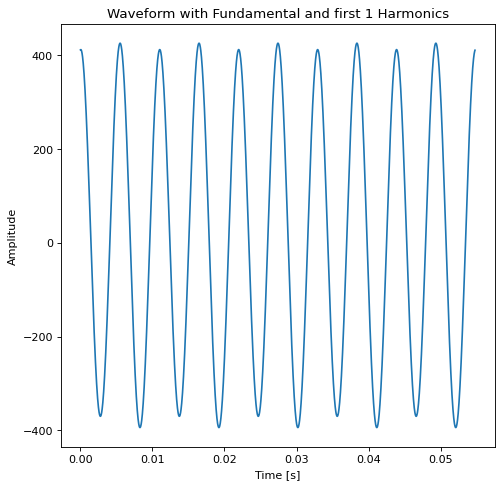

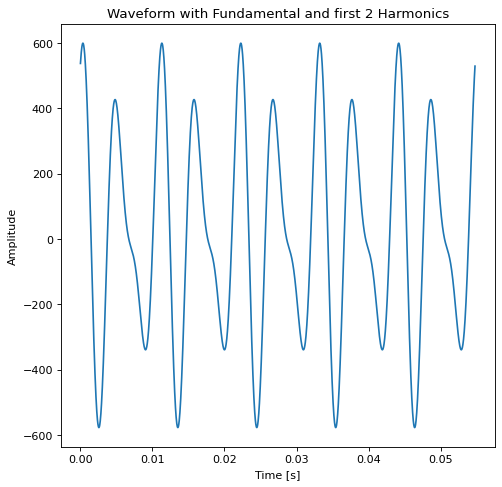

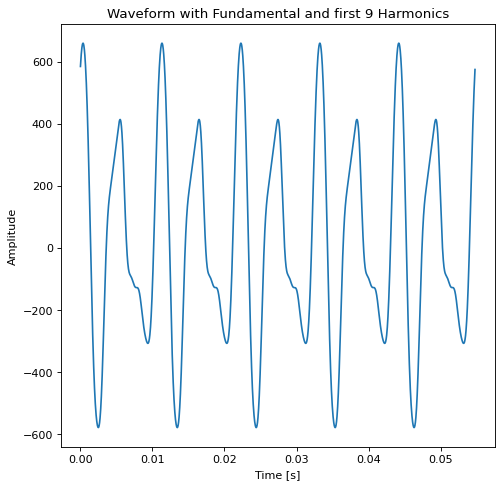

In [11]:
# Plot waveform considering up to 2 harmonics (fundamental + 1st harmonic)
n = 2
plot_waveform_with_n_harmonics(n, a_n, b_n, f0, t)

# Plot waveform considering up to 3 harmonics (fundamental + 1st and 2nd harmonics)
n = 3
plot_waveform_with_n_harmonics(n, a_n, b_n, f0, t)

n = 10
plot_waveform_with_n_harmonics(n, a_n, b_n, f0, t)

In [12]:

# Play waveform considering up to 2 harmonics (fundamental + 1st harmonic)
n = 10

# Play the waveform with up to n harmonics
play_waveform_with_n_harmonics(n, a_n, b_n, f0, t, sample_rate, 20)

## Chart composition

In [13]:
def plot_2x2_waveforms(t, data, a_n, b_n, f0):
    # Initialize a figure with 4 subplots arranged in a 2x2 grid
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # Each subplot is (4,4), so total (8,8)
    
    # (1) Plot the original waveform
    axs[0, 0].plot(t, data, label="Original Waveform", color='blue')
    axs[0, 0].set_title("Original Waveform")
    axs[0, 0].set_xlabel("Time [s]")
    axs[0, 0].set_ylabel("Amplitude")
    # axs[0, 0].legend()

    # (2) Plot the fundamental frequency (n=1 harmonic)
    fundamental = a_n[1] * np.cos(2 * np.pi * 1 * f0 * t) + b_n[1] * np.sin(2 * np.pi * 1 * f0 * t)
    axs[0, 1].plot(t, fundamental, label="Fundamental Frequency", color='orange')
    axs[0, 1].set_title(f"Fundamental Frequency f0={f0:.0f}Hz (n=1)")
    axs[0, 1].set_xlabel("Time [s]")
    axs[0, 1].set_ylabel("Amplitude")
    # axs[0, 1].legend()

    # (3) Plot the 1st harmonic (n=2 harmonic)
    first_harmonic = a_n[2] * np.cos(2 * np.pi * 2 * f0 * t) + b_n[2] * np.sin(2 * np.pi * 2 * f0 * t)
    axs[1, 0].plot(t, first_harmonic, label="1st Harmonic", color='green')
    axs[1, 0].set_title(f"1st Harmonic f={2*f0:.0f}Hz (n=2)")
    axs[1, 0].set_xlabel("Time [s]")
    axs[1, 0].set_ylabel("Amplitude")
    # axs[1, 0].legend()

    # (4) Plot the sum of fundamental and 9 harmonics (n=1 to n=10)
    sum_of_harmonics = np.zeros(len(t))
    for i in range(1, 11):  # Sum from n=1 to n=10 (fundamental + 9 harmonics)
        sum_of_harmonics += a_n[i] * np.cos(2 * np.pi * i * f0 * t) + b_n[i] * np.sin(2 * np.pi * i * f0 * t)
    
    axs[1, 1].plot(t, sum_of_harmonics, label="Fundamental + 9 Harmonics", color='red')
    axs[1, 1].plot(t, data, label="Original Waveform", color='blue', linestyle='dotted')
    axs[1, 1].set_title("Fundamental + first 9 Harmonics")
    axs[1, 1].set_xlabel("Time [s]")
    axs[1, 1].set_ylabel("Amplitude")
    axs[1, 1].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # 
    filename = f"{os.path.splitext(WAV_FILE_NAME)[0]}.png"
    plt.savefig(filename)
    print(f"Saved image to file {filename}")    
    
    # Show the plots
    plt.show()


Saved image to file Everybody nota 3.2.png


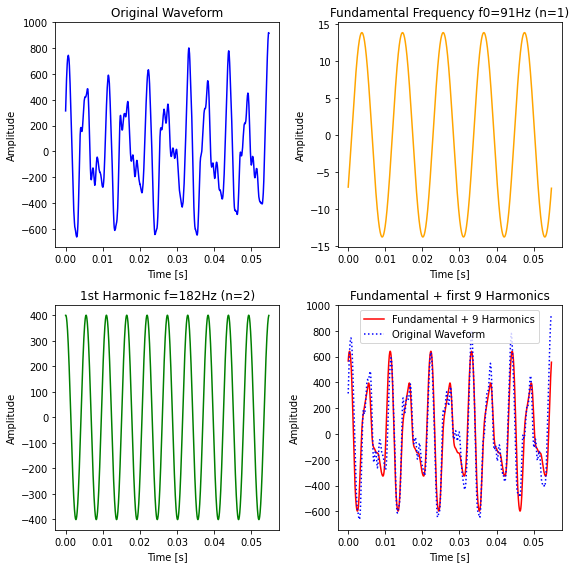

In [14]:
plot_2x2_waveforms(t, data, a_n, b_n, f0)

In [15]:
f0

91.22879602813404

# 3d plot of Fourier coefficients

In [19]:
def plot_fourier_coefficients_3d(a_n, b_n):
    # Generate n values (harmonic numbers)
    n_values = np.arange(len(a_n))  # n values from 0 to the number of harmonics
    
    # Create a 3D figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot a_n and b_n in 3D space
    ax.scatter(n_values, a_n, b_n, color='purple', label="Fourier Coefficients")

    # Set labels
    ax.set_xlabel("Harmonic Number (n)")
    ax.set_ylabel("Cosine Coefficient (a_n)")
    ax.set_zlabel("Sine Coefficient (b_n)")
    ax.set_title("3D Plot of Fourier Coefficients ( a_n ) and ( b_n )")

    # Display legend and plot
    ax.legend()
    plt.show()

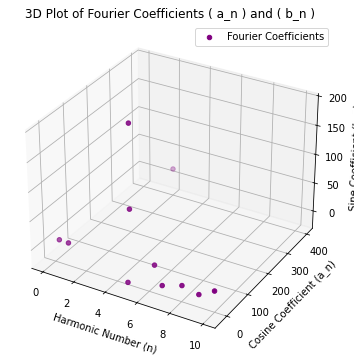

In [20]:
plot_fourier_coefficients_3d(a_n, b_n)